In [270]:
from src.utils.myOptimization import (
    AlphaFairnesstorch,
    solveIndProblem, solve_closed_form, solve_coupled_group_alpha, compute_coupled_group_obj
)
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.fairness.cal_fair_penalty import atkinson_loss, mean_abs_dev, compute_fairness_grad,mean_abs_dev, compute_group_accuracy_parity

import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import pandas as pd

from src.utils.features import get_all_features
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Define Alpha & Q

In [271]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 2,
    "Q": 2000,
    "epochs": 100,
    "lambdas": 1.0,
    "lr": 0.01
}

# with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "w") as f:
#     json.dump(params, f, indent=4)

# import json

# with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_twoStage.json", "r") as f:
#     params = json.load(f)

n_sample = params["n_sample"]
alpha    = params["alpha"]
Q        = params["Q"]
epochs   = params["epochs"]
lambdas  = params["lambdas"]
lr       = params["lr"]


In [272]:
df = pd.read_csv('E:\\myREPO\\Fairness-Decision-Focused-Loss\\Organized-FDFL\\src\\data\\data.csv')
df = df.sample(n=n_sample,random_state=42)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values) * 100
cost = np.maximum(cost, 1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
true_benefit = np.array(df['benefit'].values) * 100
true_benefit = np.maximum(true_benefit, 1) 

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values)

## Prediction Model

In [273]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)
    


class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

In [274]:

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(true_benefit, dtype=torch.float32)
# Split the data, including cost and race
X_train, X_test, y_train, y_test, race_train, race_test, cost_train, cost_test = train_test_split(
    X_tensor, y_tensor, race, torch.tensor(cost, dtype=torch.float32), test_size=0.5, random_state=42
)


## Training Function

In [275]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time # Added for timing

# ------------------------------------------------------------------
#  Fairness helpers (assuming these are defined elsewhere in your code)
# ------------------------------------------------------------------
# compute_individual_fairness(pred, true, race)
# compute_group_accuracy_parity(pred, true, race)
# solveGroupProblem(benefit, cost, race, alpha, Q)
# alpha_fairness_group_utilities(benefit, d, race, alpha)
# atkinson_loss(...)
# mean_abs_dev(...)
# solve_coupled_group_alpha(...)
# compute_coupled_group_obj(...)
# solve_closed_form(...)
# AlphaFairnesstorch(...)
# ------------------------------------------------------------------
#  TRAIN + EVALUATE FUNCTION
# ------------------------------------------------------------------
def train_fair_model_logged(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="None", group=True,
        num_epochs=30, lr=1e-3, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Train a fairness–aware predictor and log train-loss, test-MSE,
    test-normalised-regret, test-fairness, per-group MSE, per-group
    decision objectives, and total training time.
    """
    # -------------------------- type-check -----------------------------
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32,device=device)
        X_test  = torch.tensor(X_test, dtype=torch.float32,device=device)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.float32,device=device)
        y_test  = torch.tensor(y_test, dtype=torch.float32,device=device)
    if not isinstance(race_train, torch.Tensor):
        race_train = torch.tensor(race_train, dtype=torch.float32, device=device)
        race_test  = torch.tensor(race_test, dtype=torch.float32, device=device)
    # -------------------------- dataloaders ------------------------
    train_ds = TensorDataset(X_train.to(device), y_train.to(device), race_train.to(device))
    if batch_size is None:
        batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # -------------------------- model & opt ------------------------
    model  = model_class(input_dim).to(device)
    optim  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit   = nn.MSELoss()

    # -------------------------- logs -------------------------------
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []
    # New logs for group-wise data
    unique_groups = torch.unique(race_test).cpu().numpy()
    per_group_mse_log = {g: [] for g in unique_groups}
    # For group=True, this will store the mean utility per group
    per_group_decision_obj_log = {g: [] for g in unique_groups}


    # -------------------------- training loop ----------------------
    start_time = time.time() # Start timer
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for x_b, y_b, r_b in train_loader:
            pred_b = model(x_b).squeeze()
            pred_b = torch.maximum(pred_b, torch.tensor(1.0, device=device))  # Ensure predictions are >= 1.0
            mse    = crit(pred_b, y_b)

            # fairness penalty
            if fairness_type == "acc_parity":
                fair_pen = compute_group_accuracy_parity(pred_b, y_b, r_b)
            elif fairness_type == "atkinson":
                fair_pen = atkinson_loss(pred_b, y_b, race=race_train,
                            mode = 'between' if group else 'individual')
            elif fairness_type == "mad":
                fair_pen = mean_abs_dev(pred_b, y_b, race=race_train,
                            mode = 'between' if group else 'individual')
            else:
                fair_pen = torch.tensor(0.0, device=device)
            fair_pen = fair_pen.to(device)
            loss = mse + lambda_fair * fair_pen
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item() * x_b.size(0)

        loss_log.append(epoch_loss / len(train_ds))

        # ----------------- evaluation on the held-out set ----------
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test.to(device)).squeeze().cpu()
        mse_val = ((pred_test - y_test).pow(2)).mean().item()
        mse_log.append(mse_val)

        # (1) NEW: Per-group MSE calculation
        for g in unique_groups:
            mask = race_test.cpu() == g
            group_mse = ((pred_test[mask] - y_test[mask]).pow(2)).mean().item()
            per_group_mse_log[g].append(group_mse)

        # ensure positivity for optimisation step
        pred_b_np  = pred_test.numpy().reshape(-1, 1)
        pred_b_np  = np.maximum(pred_b_np, 1)

        # regret on test set
        race_np    = race_test.cpu().numpy()
        if group:
            pred_b_np = pred_test.numpy().reshape(-1)
            y_test_np = y_test.cpu().numpy().reshape(-1) if isinstance(y_test, torch.Tensor) else np.array(y_test).reshape(-1)
            cost_test_np = cost_test.numpy().reshape(-1) if isinstance(cost_test, torch.Tensor) else np.array(cost_test).reshape(-1)
            race_np = race_test.cpu().numpy().reshape(-1) if isinstance(race_test, torch.Tensor) else np.array(race_test).reshape(-1)

            sol_pred = solve_coupled_group_alpha(pred_b_np, cost_test_np, race_np, alpha=alpha, Q=Q)
            sol_true = solve_coupled_group_alpha(y_test_np, cost_test_np, race_np, alpha=alpha, Q=Q)
            true_obj = compute_coupled_group_obj(sol_true, y_test_np, race_np, alpha=alpha)
            pred_obj = compute_coupled_group_obj(sol_pred, y_test_np, race_np, alpha=alpha)

            # (2) NEW: Per-group decision objective (mean utility)
            util_pred = y_test_np * sol_pred # Utility = benefit * decision
            for g in unique_groups:
                mask = race_np == g
                # Calculate mean utility for predictions in the group
                group_decision_obj = util_pred[mask].mean()
                per_group_decision_obj_log[g].append(group_decision_obj)



        else: # individual fairness case
            b_pred = pred_b_np.flatten()
            b_true = y_test.flatten()
            c_vec = cost_test.flatten()
            ones_array = np.ones_like(b_pred)

            # solve the individual problem
            sol_pred_i, _ = solve_closed_form(ones_array ,b_pred, c_vec, alpha=alpha, Q=Q)
            sol_true_i, _ = solve_closed_form(ones_array,b_true, c_vec, alpha=alpha, Q=Q)

            # build torch‐tensors of utils = benefit * decision
            util_true = torch.tensor(b_true * sol_true_i, dtype=torch.float32, device=device)
            util_pred = torch.tensor(b_true * sol_pred_i, dtype=torch.float32, device=device)

            true_obj = AlphaFairnesstorch(util_true, alpha).item()
            pred_obj = AlphaFairnesstorch(util_pred, alpha).item()

            # (2) NEW: Per-group decision objective (mean utility)
            for g in unique_groups:
                mask = race_np == g
                # Calculate mean utility for predictions in the group
                group_decision_obj = util_pred[mask].mean().item()
                per_group_decision_obj_log[g].append(group_decision_obj)


        norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regret_log.append(norm_regret)




        # fairness on test set
        if fairness_type == "acc_parity":
            fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
        elif fairness_type == "atkinson":
            fair_val = atkinson_loss(pred_test,y_test, race_test,
                                     mode = 'between' if group else 'individual' )
        elif fairness_type == "mad":
            fair_val = mean_abs_dev(pred_test,y_test, race_test,
                                     mode = 'between' if group else 'individual' )
        else: # when no fairness
            fair_val = torch.tensor(0.0, device=device)
        fairness_log.append(fair_val)

        # ----------- progress print every 5 epochs -----------------
        if epoch == 1 or epoch % 10 == 0:
            msg = (f"Epoch {epoch:02d}/{num_epochs} | "
                   f"Train-Loss {loss_log[-1]:.4f} | "
                   f"Test-MSE {mse_val:.4f} | Regret {norm_regret:.4f}")
            if fair_val is not None:
                msg += f" | Fair {fair_val:.4f}"
            # print(msg)

    end_time = time.time() # End timer
    training_time = end_time - start_time # (3) NEW: Calculate total training time
    model.eval()

    return model, {"loss_log": loss_log,
                   "mse_log": mse_log,
                   "regret_log": regret_log,
                   "fairness_log": fairness_log,
                   "training_time": training_time,
                   "per_group_mse": per_group_mse_log,
                   "per_group_decision_objective": per_group_decision_obj_log,
                   }

# Training Group (Pred+Opt)

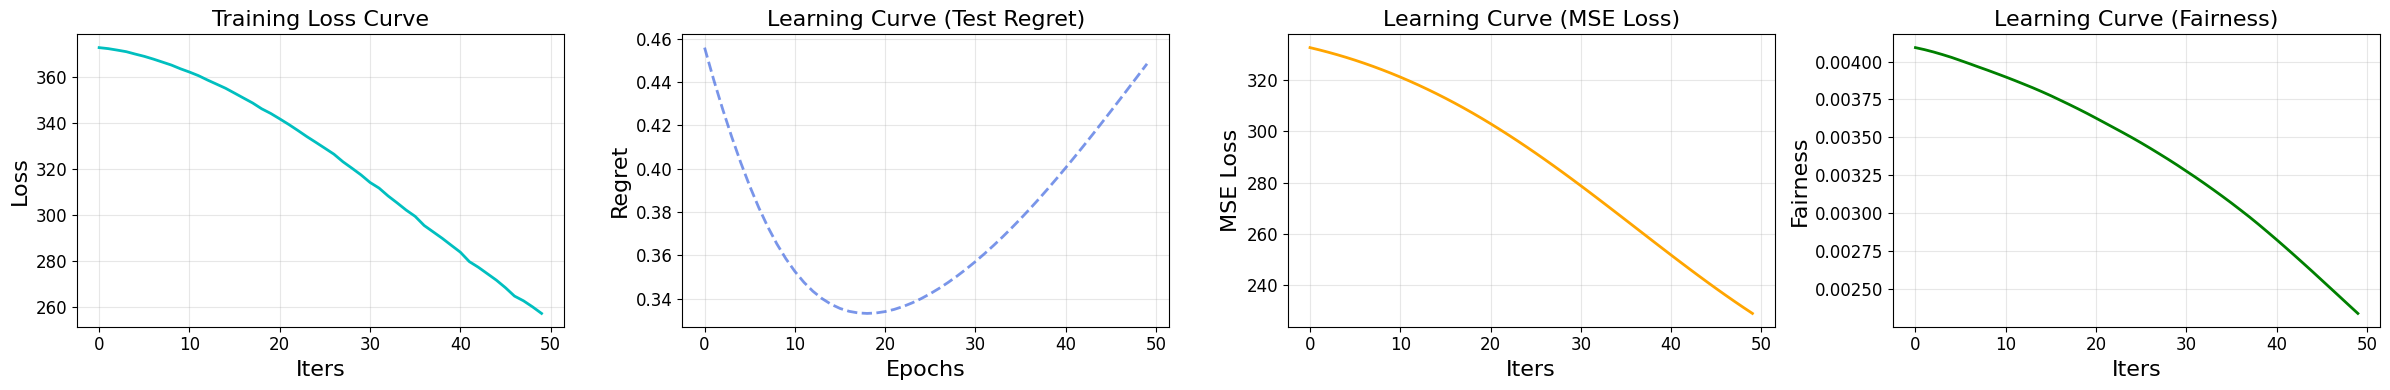

In [276]:
model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=2, Q=Q,
    lambda_fair=1,
    fairness_type="atkinson", 
    num_epochs=50, lr=0.001,
    group=True
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Evaluation

In [277]:
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

# Assume train_fair_model_logged and FairRiskPredictor are defined as before.
# Assume X_train, y_train, race_train, X_test, y_test, race_test, cost_test, Q are loaded.

def train_many_trials(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=50, lr=1e-3, batch_size=None,
        n_trials=10, base_seed=2025, group=True,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Run `train_fair_model_logged` for `n_trials` and average all results,
    including detailed group-wise metrics.
    """
    # Use a single defaultdict to store lists of final metrics from each trial
    trial_logs = defaultdict(list)

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f"\n--- Trial {t+1}/{n_trials} (Seed: {seed}) ---")

        model, logs = train_fair_model_logged(
            X_train, y_train, race_train, X_test, y_test, race_test, cost_test,
            model_class, input_dim, alpha, Q,
            lambda_fair=lambda_fair, fairness_type=fairness_type,
            num_epochs=num_epochs, lr=lr, batch_size=batch_size,
            dropout_rate=dropout_rate, weight_decay=weight_decay,
            device=device, group=group
        )

        # --- Collect final metrics from the logs of the current trial ---
        # Scalar metrics
        trial_logs['regret'].append(logs['regret_log'][-1])
        trial_logs['mse'].append(logs['mse_log'][-1])
        trial_logs['fairness'].append(logs['fairness_log'][-1])
        trial_logs['training_time'].append(logs['training_time'])

        # Group-wise MSE
        for g_id, g_log in logs['per_group_mse'].items():
            if g_log: # Ensure log is not empty
                trial_logs[f'G{int(g_id)}_mse'].append(g_log[-1])

        # Group-wise decision objective (only if group=True)
        for g_id, g_log in logs['per_group_decision_objective'].items():
            if g_log: # Ensure log is not empty
                trial_logs[f'G{int(g_id)}_decision_obj'].append(g_log[-1])


    # --- Averaging and Reporting ---
    print("\n" + "="*60)
    print("      AVERAGED RESULTS ACROSS ALL TRIALS")
    print("="*60)

    avg_results = {}
    print("\n--- Overall Performance ---")
    for key in ['regret', 'mse', 'fairness', 'training_time']:
        vals = trial_logs[key]
        avg_results[key]      = np.mean(vals) if vals else np.nan
        avg_results[f'{key}_std'] = np.std(vals) if vals else np.nan
        print(f"[{key.upper():>15s}] final mean = {avg_results[key]:.4f}  |  std = {avg_results[f'{key}_std']:.4f}")

    for gkey in sorted(k for k in trial_logs if k.startswith('G')):
        vals = trial_logs[gkey]
        avg_results[gkey]          = np.mean(vals) if vals else np.nan
        avg_results[f'{gkey}_std'] = np.std(vals) if vals else np.nan
        print(f"[{gkey.upper():>15s}] final mean = {avg_results[gkey]:.4f}  |  std = {avg_results[f'{gkey}_std']:.4f}")

    return avg_results, model



In [278]:
# avg_logs = train_many_trials(
#     X_train, y_train, race_train,
#     X_test,  y_test,  race_test,
#     cost_test,
#     model_class=FairRiskPredictor,
#     input_dim=X_train.shape[1],
#     alpha=alpha, beta=beta, Q=Q,
#     lambda_fair=lambdas,
#     fairness_type="mad",
#     num_epochs=30,
#     lr=lr,
#     n_trials=2,
#     group=False
# )

# # # Visualise the averaged learning curves
# # visLearningCurve(avg_logs["loss_log"],
# #                  avg_logs["regret_log"],
# #                  avg_logs["mse_log"],
# #                  avg_logs["fairness_log"])


In [279]:
lr=1e-3

In [280]:
# =================================================================
#  MAIN EXPERIMENT LOOP
# =================================================================
# Dummy values for demonstration
epochs = 50
lr = 0.001
Q = 2000

# --- Define hyperparameter grid ---
alphas = [0.5, 0.8, 1.5, 2.0]
group_settings = [True, False]
fairness_types = ['mad', 'atkinson']
results_list = []

for group in group_settings:
    for fairness in fairness_types:
        if fairness == 'mad':
            fairness_lambdas = [0, 1, 0.01]
        elif fairness == 'atkinson':
            fairness_lambdas = [0, 1, 10]
        else:
            fairness_lambdas = [0, 1.0]

        for lam in fairness_lambdas:
            for alpha in alphas:
                run_params = {
                    'Group':    group,
                    'Alpha':    alpha,
                    'Lambda':   lam,
                    'Fairness': fairness
                }
                print("\n" + "="*70)
                print(f"RUNNING EXPERIMENT: {run_params}")
                print("="*70)

                avg_logs, model = train_many_trials(
                    X_train, y_train, race_train,
                    X_test, y_test, race_test,
                    cost_test,
                    # model_class= FairRiskPredictor,
                    model_class= LinearRegressionModel,
                    input_dim=X_train.shape[1],
                    alpha=alpha, Q=Q,
                    lambda_fair=lam,
                    fairness_type=fairness,
                    num_epochs=epochs,
                    lr=1e-3,
                    n_trials=3, # Using 5 for a quick run
                    group=group
                )
                model_name = f"model_{fairness}_{lam}_twoStage_{group}_{alpha}_LR.pth"
                model_path = f"E:/myREPO/Fairness-Decision-Focused-Loss/Organized-FDFL/src/models/twoStage/{model_name}"
                torch.save(model.state_dict(), model_path) # type: ignore[arg-type]

                final_run_results = run_params.copy()
                final_run_results.update(avg_logs)
                results_list.append(final_run_results)

# --- Present Final Results in a DataFrame ---
results_df = pd.DataFrame(results_list)

main_cols = ['Group', 'Alpha', 'Lambda', 'Fairness', 'regret', 'mse', 'fairness', 'training_time']
other_cols = sorted([col for col in results_df.columns if col not in main_cols])
results_df = results_df[main_cols + other_cols]

print("\n\n" + "="*80)
print("             GRID SEARCH COMPLETE")
print("="*80)
print("\n--- Experiment Results Summary (Pandas DataFrame) ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 180):
    print(results_df)

results_df.to_csv("2-stage-res-new-NN.csv", index=False)


RUNNING EXPERIMENT: {'Group': True, 'Alpha': 0.5, 'Lambda': 0, 'Fairness': 'mad'}

--- Trial 1/3 (Seed: 2025) ---

--- Trial 2/3 (Seed: 2026) ---

--- Trial 3/3 (Seed: 2027) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.0948  |  std = 0.0056
[            MSE] final mean = 307.8661  |  std = 1.1422
[       FAIRNESS] final mean = 63.1660  |  std = 1.5567
[  TRAINING_TIME] final mean = 1.3699  |  std = 0.0474
[G0_DECISION_OBJ] final mean = 2.6927  |  std = 0.0485
[         G0_MSE] final mean = 293.4137  |  std = 0.7940
[G1_DECISION_OBJ] final mean = 13.0548  |  std = 0.2544
[         G1_MSE] final mean = 419.7457  |  std = 3.8870

RUNNING EXPERIMENT: {'Group': True, 'Alpha': 0.8, 'Lambda': 0, 'Fairness': 'mad'}

--- Trial 1/3 (Seed: 2025) ---

--- Trial 2/3 (Seed: 2026) ---

--- Trial 3/3 (Seed: 2027) ---

      AVERAGED RESULTS ACROSS ALL TRIALS

--- Overall Performance ---
[         REGRET] final mean = 0.0017  |  std = 0.00

In [281]:

# Run 1, Linear Reg, lr = 1e-3
# Run 2, NN, lr = 1e-3
results_df

,Group,Alpha,Lambda,Fairness,regret,mse,fairness,training_time,G0_decision_obj,G0_decision_obj_std,G0_mse,G0_mse_std,G1_decision_obj,G1_decision_obj_std,G1_mse,G1_mse_std,fairness_std,mse_std,regret_std,training_time_std
0,True,0.5,0.00,mad,0.094803,307.866089,63.166027,1.369883,2.692689,0.048547,293.413696,0.794009,13.054752,0.254350,419.745748,3.887010,1.556731,1.142226,0.005592,0.047410
1,True,0.8,0.00,mad,0.001669,307.866089,63.166027,1.394871,1.374538,0.006090,293.413696,0.794009,10.743255,0.060468,419.745748,3.887010,1.556731,1.142226,0.000099,0.081373
2,True,1.5,0.00,mad,0.032777,307.866089,63.166027,1.363257,1.258391,0.002505,293.413696,0.794009,3.904333,0.038200,419.745748,3.887010,1.556731,1.142226,0.001537,0.025171
3,True,2.0,0.00,mad,0.428187,307.866089,63.166027,1.375510,1.296864,0.006417,293.413696,0.794009,1.618769,0.019482,419.745748,3.887010,1.556731,1.142226,0.032558,0.074817
4,True,0.5,1.00,mad,0.090361,309.578227,63.537685,1.345532,2.648687,0.067925,295.040802,0.595842,12.950784,0.218385,422.116170,3.573754,1.494426,0.932965,0.004276,0.072542
5,True,0.8,1.00,mad,0.001586,309.578227,63.537685,1.385440,1.369569,0.007117,295.040802,0.595842,10.707688,0.058890,422.116170,3.573754,1.494426,0.932965,0.000075,0.051560
6,True,1.5,1.00,mad,0.031182,309.578227,63.537685,1.398132,1.262017,0.003055,295.040802,0.595842,3.919072,0.039956,422.116170,3.573754,1.494426,0.932965,0.001273,0.047109
7,True,2.0,1.00,mad,0.399022,309.578227,63.537685,1.382885,1.301504,0.006222,295.040802,0.595842,1.629050,0.018676,422.116170,3.573754,1.494426,0.932965,0.027187,0.056023
8,True,0.5,0.01,mad,0.094777,307.871470,63.164577,1.382625,2.692828,0.048896,293.419383,0.788291,13.056131,0.254405,419.748535,3.882049,1.557768,1.136169,0.005584,0.062308
9,True,0.8,0.01,mad,0.001668,307.871470,63.164577,1.408580,1.374527,0.006128,293.419383,0.788291,10.743238,0.060465,419.748535,3.882049,1.557768,1.136169,0.000099,0.038910


In [282]:
results_df[other_cols]

,G0_decision_obj,G0_decision_obj_std,G0_mse,G0_mse_std,G1_decision_obj,G1_decision_obj_std,G1_mse,G1_mse_std,fairness_std,mse_std,regret_std,training_time_std
0,2.692689,0.048547,293.413696,0.794009,13.054752,0.254350,419.745748,3.887010,1.556731,1.142226,0.005592,0.047410
1,1.374538,0.006090,293.413696,0.794009,10.743255,0.060468,419.745748,3.887010,1.556731,1.142226,0.000099,0.081373
2,1.258391,0.002505,293.413696,0.794009,3.904333,0.038200,419.745748,3.887010,1.556731,1.142226,0.001537,0.025171
3,1.296864,0.006417,293.413696,0.794009,1.618769,0.019482,419.745748,3.887010,1.556731,1.142226,0.032558,0.074817
4,2.648687,0.067925,295.040802,0.595842,12.950784,0.218385,422.116170,3.573754,1.494426,0.932965,0.004276,0.072542
5,1.369569,0.007117,295.040802,0.595842,10.707688,0.058890,422.116170,3.573754,1.494426,0.932965,0.000075,0.051560
6,1.262017,0.003055,295.040802,0.595842,3.919072,0.039956,422.116170,3.573754,1.494426,0.932965,0.001273,0.047109
7,1.301504,0.006222,295.040802,0.595842,1.629050,0.018676,422.116170,3.573754,1.494426,0.932965,0.027187,0.056023
8,2.692828,0.048896,293.419383,0.788291,13.056131,0.254405,419.748535,3.882049,1.557768,1.136169,0.005584,0.062308
9,1.374527,0.006128,293.419383,0.788291,10.743238,0.060465,419.748535,3.882049,1.557768,1.136169,0.000099,0.038910


In [283]:
# Initialize the models
model_LR = LinearRegressionModel(input_dim=X_train.shape[1])
model_NN = FairRiskPredictor(input_dim=X_train.shape[1])

# Load the saved weights
model_LR.load_state_dict(torch.load("2-stage-pred-model-LR.pth"))
model_NN.load_state_dict(torch.load("2-stage-pred-model-NN.pth"))

model_LR.eval()
model_NN.eval()

FairRiskPredictor(
  (model): Sequential(
    (0): Linear(in_features=152, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)